In [ ]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [ ]:
#Download your api kaggle.jdon from kaggle and upload it here
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lokadevm","key":"460dc02f59f07c98338841eab1442586"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d tawsifurrahman/tuberculosis-tb-chest-xray-dataset

Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset
License(s): copyright-authors
 98% 649M/663M [00:07<00:00, 159MB/s]
100% 663M/663M [00:07<00:00, 90.8MB/s]


In [ ]:
#unziping the file
from zipfile import ZipFile
file_name = '/content/tuberculosis-tb-chest-xray-dataset.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
! pip install split-folders


In [ ]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Define paths
data_dir = '/content/TB_Chest_Radiography_Database'
normal_dir = os.path.join(data_dir, 'Normal')
tb_dir = os.path.join(data_dir, 'Tuberculosis')

# Load images and labels
normal_images = [os.path.join(normal_dir, img) for img in os.listdir(normal_dir)]
tb_images = [os.path.join(tb_dir, img) for img in os.listdir(tb_dir)]
images = normal_images + tb_images
labels = [0] * len(normal_images) + [1] * len(tb_images)  # 0 for normal, 1 for tuberculosis

# Resize and normalize images
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))  # Resize to common size
    img = img.astype(np.float32) / 255.0  # Normalize pixel values
    return img

# Preprocess all images
processed_images = [preprocess_image(img) for img in images]

# Split dataset into train and test sets
train_images, test_images, train_labels, test_labels = train_test_split(processed_images, labels, test_size=0.2, random_state=42)

# Convert to TensorFlow tensors
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

# Shuffle and batch the datasets
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(buffer_size=len(train_images)).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

# Count the number of samples in each dataset
train_count = len(train_images)
test_count = len(test_images)

# Print the number of samples in each dataset
print("Number of samples in the Train Dataset:", train_count)
print("Number of samples in the Test Dataset:", test_count)


Number of samples in the Train Dataset: 3360
Number of samples in the Test Dataset: 840


In [ ]:
pip install keras-tuner


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.5 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define paths
data_dir = '/content/TB_Chest_Radiography_Database'
normal_dir = os.path.join(data_dir, 'Normal')
tb_dir = os.path.join(data_dir, 'Tuberculosis')

# Load images and labels
normal_images = [os.path.join(normal_dir, img) for img in os.listdir(normal_dir)]
tb_images = [os.path.join(tb_dir, img) for img in os.listdir(tb_dir)]
images = normal_images + tb_images
labels = [0] * len(normal_images) + [1] * len(tb_images)  # 0 for normal, 1 for tuberculosis

# Resize and normalize images
def preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (128, 128))  # Resize to common size
    img = img.astype(np.float32) / 255.0  # Normalize pixel values
    return img

# Preprocess all images
processed_images = [preprocess_image(img) for img in images]
processed_images = np.expand_dims(processed_images, axis=-1)  # Expand dimensions to add channel

# Convert labels to the same shape as the images for segmentation
processed_labels = [preprocess_image(img) for img in images]
processed_labels = np.expand_dims(processed_labels, axis=-1)  # Expand dimensions to add channel

# Split dataset into train and test sets
train_images, test_images, train_labels, test_labels = train_test_split(processed_images, processed_labels, test_size=0.2, random_state=42)

# Convert to TensorFlow tensors
train_images = np.array(train_images)
test_images = np.array(test_images)
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

# Create TensorFlow datasets
BATCH_SIZE = 32
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(buffer_size=len(train_images)).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(BATCH_SIZE)

# Define U-Net model architecture
def unet_model(input_shape, dropout_rate=0.5):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    c9 = layers.Dropout(dropout_rate)(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

# Define input shape
input_shape = (128, 128, 1)

# Define hyperparameters for tuning
learning_rates = [0.001, 0.0001]
dropout_rates = [0.5, 0.7]
epochs = 10
batch_size = 32
early_stopping_patience = 5  # Adjusted early stopping patience

best_model = None
best_accuracy = 0.0

# Perform hyperparameter tuning
for learning_rate in learning_rates:
    for dropout_rate in dropout_rates:
        print(f"Training model with learning rate: {learning_rate}, dropout rate: {dropout_rate}")

        # Create the U-Net model
        model = unet_model(input_shape, dropout_rate)

        # Compile the model
        optimizer = optimizers.Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

        # Define callbacks
        early_stopping = EarlyStopping(monitor='val_loss', patience=early_stopping_patience, restore_best_weights=True)
        model_checkpoint = ModelCheckpoint(filepath='unet_best_model.h5', monitor='val_loss', save_best_only=True)

        # Train the model
        history = model.fit(train_dataset, epochs=epochs, batch_size=batch_size,
                            validation_data=test_dataset, callbacks=[early_stopping, model_checkpoint])

        # Evaluate the model
        test_loss, test_accuracy = model.evaluate(test_dataset)

        print(f"Test accuracy for current configuration: {test_accuracy}")

        # Check if current model is the best so far
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            best_model = model

print("Hyperparameter tuning completed.")
print(f"Best test accuracy: {best_accuracy}")

# Save the best model
best_model.save('best_unet_model.h5')


Training model with learning rate: 0.001, dropout rate: 0.5
Epoch 1/10
105/105 [==============================] - ETA: 0s - loss: 0.5801 - accuracy: 0.0293

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


105/105 [==============================] - 84s 478ms/step - loss: 0.5801 - accuracy: 0.0293 - val_loss: 0.5400 - val_accuracy: 0.0283
Epoch 2/10
105/105 [==============================] - 48s 454ms/step - loss: 0.5432 - accuracy: 0.0302 - val_loss: 0.5383 - val_accuracy: 0.0283
Epoch 3/10
105/105 [==============================] - 54s 516ms/step - loss: 0.5421 - accuracy: 0.0302 - val_loss: 0.5377 - val_accuracy: 0.0283
Epoch 4/10
105/105 [==============================] - 47s 451ms/step - loss: 0.5418 - accuracy: 0.0302 - val_loss: 0.5381 - val_accuracy: 0.0283
Epoch 5/10
105/105 [==============================] - 56s 530ms/step - loss: 0.5414 - accuracy: 0.0302 - val_loss: 0.5375 - val_accuracy: 0.0283
Epoch 6/10
105/105 [==============================] - 56s 531ms/step - loss: 0.5414 - accuracy: 0.0302 - val_loss: 0.5373 - val_accuracy: 0.0283
Epoch 7/10
105/105 [==============================] - 47s 450ms/step - loss: 0.5413 - accuracy: 0.0302 - val_loss: 0.5374 - val_accuracy: 0.0

In [ ]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Define paths
data_dir = '/content/TB_Chest_Radiography_Database'
normal_dir = os.path.join(data_dir, 'Normal')
tb_dir = os.path.join(data_dir, 'Tuberculosis')

# Load images and labels
normal_images = [os.path.join(normal_dir, img) for img in os.listdir(normal_dir)]
tb_images = [os.path.join(tb_dir, img) for img in os.listdir(tb_dir)]
images = normal_images + tb_images
labels = [0] * len(normal_images) + [1] * len(tb_images)  # 0 for normal, 1 for tuberculosis

# Resize and normalize images
def preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (128, 128))  # Resize to common size
    img = img.astype(np.float32) / 255.0  # Normalize pixel values
    return img

# Preprocess all images
processed_images = [preprocess_image(img) for img in images]
processed_images = np.expand_dims(processed_images, axis=-1)  # Expand dimensions to add channel

# Convert labels to the same shape as the images for segmentation
processed_labels = [preprocess_image(img) for img in images]
processed_labels = np.expand_dims(processed_labels, axis=-1)  # Expand dimensions to add channel

# Split dataset into train and test sets
train_images, test_images, train_labels, test_labels = train_test_split(processed_images, processed_labels, test_size=0.2, random_state=42)

# Convert to TensorFlow tensors
train_images = np.array(train_images)
test_images = np.array(test_images)
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

# Create TensorFlow datasets
BATCH_SIZE = 32
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(buffer_size=len(train_images)).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(BATCH_SIZE)

# Load the best model
best_model = models.load_model('best_unet_model.h5')

# Predict on the test dataset
y_pred_prob = best_model.predict(test_dataset)
y_pred = np.where(y_pred_prob > 0.5, 1, 0)  # Threshold probabilities to get binary predictions

# Get true labels
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate performance metrics
accuracy = np.trace(cm) / np.sum(cm)
precision = cm[1, 1] / np.sum(cm[:, 1])
recall = cm[1, 1] / np.sum(cm[1, :])
sensitivity = recall

# Print the performance metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("Sensitivity:", sensitivity)

# Generate a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Tuberculosis"], yticklabels=["Normal", "Tuberculosis"])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
print(classification_report(y_true, y_pred, target_names=["Normal", "Tuberculosis"]))


27/27 [==============================] - 3s 112ms/step


ValueError: unknown is not supported

In [ ]:

import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define paths
data_dir = '/content/TB_Chest_Radiography_Database'
normal_dir = os.path.join(data_dir, 'Normal')
tb_dir = os.path.join(data_dir, 'Tuberculosis')

# Load images and labels
normal_images = [os.path.join(normal_dir, img) for img in os.listdir(normal_dir)]
tb_images = [os.path.join(tb_dir, img) for img in os.listdir(tb_dir)]
images = normal_images + tb_images
labels = [0] * len(normal_images) + [1] * len(tb_images)  # 0 for normal, 1 for tuberculosis

# Resize and normalize images
def preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (128, 128))  # Resize to common size
    img = img.astype(np.float32) / 255.0  # Normalize pixel values
    return img

# Preprocess all images
processed_images = [preprocess_image(img) for img in images]
processed_images = np.expand_dims(processed_images, axis=-1)  # Expand dimensions to add channel

# Convert labels to the same shape as the images for segmentation
processed_labels = [preprocess_image(img) for img in images]
processed_labels = np.expand_dims(processed_labels, axis=-1)  # Expand dimensions to add channel

# Split dataset into train and test sets
train_images, test_images, train_labels, test_labels = train_test_split(processed_images, processed_labels, test_size=0.2, random_state=42)

# Convert to TensorFlow tensors
train_images = np.array(train_images)
test_images = np.array(test_images)
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

# Create TensorFlow datasets
BATCH_SIZE = 32
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(buffer_size=len(train_images)).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(BATCH_SIZE)

# Define U-Net model architecture
def unet_model(input_shape, dropout_rate=0.5):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    c9 = layers.Dropout(dropout_rate)(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

# Define input shape
input_shape = (128, 128, 1)

# Define hyperparameters for tuning
learning_rates = [0.001, 0.0001]
dropout_rates = [0.5, 0.7]
epochs = 10
batch_size = 32
early_stopping_patience = 5  # Adjusted early stopping patience

# Define dice loss
def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return 1 - (numerator + 1) / (denominator + 1)

# Define dice coefficient
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return (numerator + 1) / (denominator + 1)

best_model = None
best_accuracy = 0.0

# Perform hyperparameter tuning
for learning_rate in learning_rates:
    for dropout_rate in dropout_rates:
        print(f"Training model with learning rate: {learning_rate}, dropout rate: {dropout_rate}")

        # Create the U-Net model
        model = unet_model(input_shape, dropout_rate)

        # Compile the model
        optimizer = optimizers.Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss=dice_loss, metrics=[dice_coefficient])

        # Define callbacks
        early_stopping = EarlyStopping(monitor='val_loss', patience=early_stopping_patience, restore_best_weights=True)
        model_checkpoint = ModelCheckpoint(filepath='unet_best_model.h5', monitor='val_loss', save_best_only=True)

        # Train the model
        history = model.fit(train_dataset, epochs=epochs, batch_size=batch_size,
                            validation_data=test_dataset, callbacks=[early_stopping, model_checkpoint])

        # Evaluate the model
        test_loss, test_accuracy = model.evaluate(test_dataset)

        print(f"Test accuracy for current configuration: {test_accuracy}")

        # Check if current model is the best so far
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            best_model = model

print("Hyperparameter tuning completed.")
print(f"Best test accuracy: {best_accuracy}")

# Save the best model
best_model.save('best_unet_model.h5')



Training model with learning rate: 0.001, dropout rate: 0.5
Epoch 1/10
  5/105 [>.............................] - ETA: 1:50:33 - loss: 0.3988 - dice_coefficient: 0.6012

In [ ]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import ResNet50

# Define paths
data_dir = '/content/TB_Chest_Radiography_Database'
normal_dir = os.path.join(data_dir, 'Normal')
tb_dir = os.path.join(data_dir, 'Tuberculosis')

# Load images and labels
normal_images = [os.path.join(normal_dir, img) for img in os.listdir(normal_dir)]
tb_images = [os.path.join(tb_dir, img) for img in os.listdir(tb_dir)]
images = normal_images + tb_images
labels = [0] * len(normal_images) + [1] * len(tb_images)  # 0 for normal, 1 for tuberculosis

# Resize and normalize images
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))  # Resize to common size
    img = img.astype(np.float32) / 255.0  # Normalize pixel values
    return img

# Preprocess all images
processed_images = [preprocess_image(img) for img in images]

# Split dataset into train and test sets
train_images, test_images, train_labels, test_labels = train_test_split(processed_images, labels, test_size=0.2, random_state=42)

# Convert to TensorFlow tensors and ensure labels are float32
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).map(lambda x, y: (x, tf.cast(y, tf.float32)))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).map(lambda x, y: (x, tf.cast(y, tf.float32)))

# Shuffle and batch the datasets
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(buffer_size=len(train_images)).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

# Define Focal Loss
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_true = tf.convert_to_tensor(y_true, dtype=tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, dtype=tf.float32)

        alpha_t = y_true * alpha + (1 - y_true) * (1 - alpha)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        fl = -alpha_t * tf.pow((1 - p_t), gamma) * tf.math.log(tf.clip_by_value(p_t, 1e-8, 1.0))
        return tf.reduce_sum(fl, axis=-1)
    return focal_loss_fixed

# Build Feature Pyramid Network
def build_fpn(backbone):
    c3_output = backbone.get_layer("conv3_block4_out").output
    c4_output = backbone.get_layer("conv4_block6_out").output
    c5_output = backbone.get_layer("conv5_block3_out").output

    p5_output = layers.Conv2D(256, (1, 1), padding="same", name="fpn_p5")(c5_output)
    p4_output = layers.Add(name="fpn_p4")([
        layers.UpSampling2D(size=(2, 2), name="fpn_p5upsampled")(p5_output),
        layers.Conv2D(256, (1, 1), padding="same", name="fpn_c4p4")(c4_output)
    ])
    p3_output = layers.Add(name="fpn_p3")([
        layers.UpSampling2D(size=(2, 2), name="fpn_p4upsampled")(p4_output),
        layers.Conv2D(256, (1, 1), padding="same", name="fpn_c3p3")(c3_output)
    ])
    p6_output = layers.Conv2D(256, (3, 3), strides=(2, 2), padding="same", name="fpn_p6")(p5_output)
    p7_output = layers.Conv2D(256, (3, 3), strides=(2, 2), padding="same", name="fpn_p7")(tf.nn.relu(p6_output))

    return [p3_output, p4_output, p5_output, p6_output, p7_output]

# Build Classification Subnet
def build_classification_subnet(num_classes, num_anchors):
    inputs = layers.Input(shape=(None, None, 256))
    x = inputs
    for _ in range(4):
        x = layers.Conv2D(256, (3, 3), padding="same", activation="relu")(x)
    x = layers.Conv2D(num_classes * num_anchors, (3, 3), padding="same", activation="sigmoid")(x)
    outputs = layers.Reshape((-1, num_classes))(x)
    return models.Model(inputs=inputs, outputs=outputs, name="classification_subnet")

# Build Regression Subnet
def build_regression_subnet(num_anchors):
    inputs = layers.Input(shape=(None, None, 256))
    x = inputs
    for _ in range(4):
        x = layers.Conv2D(256, (3, 3), padding="same", activation="relu")(x)
    x = layers.Conv2D(num_anchors * 4, (3, 3), padding="same")(x)
    outputs = layers.Reshape((-1, 4))(x)
    return models.Model(inputs=inputs, outputs=outputs, name="regression_subnet")

# Create RetinaNet Model
def create_retinanet(input_shape, num_classes, num_anchors):
    backbone = ResNet50(include_top=False, input_shape=input_shape)
    backbone.trainable = True

    pyramid_features = build_fpn(backbone)
    classification_subnet = build_classification_subnet(num_classes, num_anchors)
    regression_subnet = build_regression_subnet(num_anchors)

    inputs = backbone.input
    classification_outputs = [classification_subnet(feature) for feature in pyramid_features]
    regression_outputs = [regression_subnet(feature) for feature in pyramid_features]

    classification_output = layers.Concatenate(axis=1, name="classification_output")(classification_outputs)
    regression_output = layers.Concatenate(axis=1, name="regression_output")(regression_outputs)

    model = models.Model(inputs=inputs, outputs=[classification_output, regression_output])
    return model

# Define input shape and number of classes
input_shape = (224, 224, 3)
num_classes = 2  # 2 classes: Normal and Tuberculosis
num_anchors = 9  # Number of anchors per feature map location

# Define hyperparameters for tuning
learning_rates = [0.001, 0.0001]
dropout_rates = [0.5, 0.7]
epochs = 10
batch_size = 32
early_stopping_patience = 5  # Adjusted early stopping patience

best_model = None
best_accuracy = 0.0

# Perform hyperparameter tuning
for learning_rate in learning_rates:
    for dropout_rate in dropout_rates:
        print(f"Training model with learning rate: {learning_rate}, dropout rate: {dropout_rate}")

        # Create the RetinaNet model
        model = create_retinanet(input_shape, num_classes, num_anchors)

        # Compile the model
        optimizer = optimizers.Adam(learning_rate=learning_rate)
        model.compile(
            optimizer=optimizer,
            loss={'classification_output': focal_loss(), 'regression_output': 'mse'},
            metrics={'classification_output': 'accuracy'}
        )

        # Define callbacks
        early_stopping = EarlyStopping(monitor='val_loss', patience=early_stopping_patience, restore_best_weights=True)
        model_checkpoint = ModelCheckpoint(filepath='retinanet_best_model.h5', monitor='val_loss', save_best_only=True)

        # Train the model
        history = model.fit(train_dataset, epochs=epochs, batch_size=batch_size,
                            validation_data=test_dataset, callbacks=[early_stopping, model_checkpoint])

        # Evaluate the model
        _, test_accuracy = model.evaluate(test_dataset)

        print(f"Test accuracy for current configuration: {test_accuracy}")

        # Check if current model is the best so far
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            best_model = model

print("Hyperparameter tuning completed.")
print(f"Best test accuracy: {best_accuracy}")

# Save the best model
best_model.save('best_retinanet_model.h5')


Training model with learning rate: 0.001, dropout rate: 0.5
Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-1-74f409498546>", line 150, in <cell line: 130>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1154, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 543, in minimize

  File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 276, in compute_gradients

Incompatible shapes: [32,9441,4] vs. [32]
	 [[{{node gradient_tape/mean_squared_error/BroadcastGradientArgs}}]] [Op:__inference_train_function_31873]

In [ ]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define paths
data_dir = '/content/TB_Chest_Radiography_Database'
normal_dir = os.path.join(data_dir, 'Normal')
tb_dir = os.path.join(data_dir, 'Tuberculosis')

# Load images and labels
normal_images = [os.path.join(normal_dir, img) for img in os.listdir(normal_dir)]
tb_images = [os.path.join(tb_dir, img) for img in os.listdir(tb_dir)]
images = normal_images + tb_images
labels = [0] * len(normal_images) + [1] * len(tb_images)  # 0 for normal, 1 for tuberculosis

# Resize and normalize images
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))  # Resize to common size
    img = img.astype(np.float32) / 255.0  # Normalize pixel values
    return img

# Preprocess all images
processed_images = [preprocess_image(img) for img in images]

# Split dataset into train and test sets
train_images, test_images, train_labels, test_labels = train_test_split(processed_images, labels, test_size=0.2, random_state=42)

# Convert to TensorFlow tensors
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).map(lambda x, y: (x, tf.cast(y, tf.float32)))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).map(lambda x, y: (x, tf.cast(y, tf.float32)))

# Shuffle and batch the datasets
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(buffer_size=len(train_images)).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

# GhostNet block
def ghost_module(x, out_channels, ratio=2, dw_size=3, strides=1, activation=True):
    init_channels = int(np.ceil(out_channels / ratio))
    new_channels = int(init_channels * (ratio - 1))

    primary_conv = layers.Conv2D(init_channels, 1, strides=strides, padding='same', use_bias=False)(x)
    primary_conv = layers.BatchNormalization()(primary_conv)
    if activation:
        primary_conv = layers.ReLU()(primary_conv)

    cheap_operation = layers.DepthwiseConv2D(dw_size, 1, padding='same', use_bias=False)(primary_conv)
    cheap_operation = layers.BatchNormalization()(cheap_operation)
    if activation:
        cheap_operation = layers.ReLU()(cheap_operation)

    out = layers.Concatenate(axis=-1)([primary_conv, cheap_operation])
    out = layers.Conv2D(out_channels, 1, padding='same', use_bias=False)(out)
    out = layers.BatchNormalization()(out)

    return out

# GhostNet model
def create_ghostnet(input_shape, num_classes, learning_rate=0.001, dropout_rate=0.5):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(16, 3, 2, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = ghost_module(x, 16)
    x = ghost_module(x, 24, strides=2)
    x = ghost_module(x, 24)

    x = ghost_module(x, 40, strides=2)
    x = ghost_module(x, 40)

    x = ghost_module(x, 80, strides=2)
    x = ghost_module(x, 80)
    x = ghost_module(x, 80)
    x = ghost_module(x, 80)

    x = ghost_module(x, 160, strides=2)
    x = ghost_module(x, 160)

    x = ghost_module(x, 320, strides=1)
    x = layers.Conv2D(1280, 1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)

    # Compile the model
    optimizer = optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Define input shape and number of classes
input_shape = (224, 224, 3)
num_classes = 2  # 2 classes: Normal and Tuberculosis

# Define hyperparameters for tuning
learning_rates = [0.001, 0.0001]
dropout_rates = [0.5, 0.7]
epochs = 10
batch_size = 32
early_stopping_patience = 5  # Adjusted early stopping patience

best_model = None
best_accuracy = 0.0

# Perform hyperparameter tuning
for learning_rate in learning_rates:
    for dropout_rate in dropout_rates:
        print(f"Training model with learning rate: {learning_rate}, dropout rate: {dropout_rate}")

        # Create the GhostNet model
        model = create_ghostnet(input_shape, num_classes, learning_rate, dropout_rate)

        # Define callbacks
        early_stopping = EarlyStopping(monitor='val_loss', patience=early_stopping_patience, restore_best_weights=True)
        model_checkpoint = ModelCheckpoint(filepath='ghostnet_best_model.h5', monitor='val_loss', save_best_only=True)

        # Train the model
        history = model.fit(train_dataset, epochs=epochs, batch_size=batch_size,
                            validation_data=test_dataset, callbacks=[early_stopping, model_checkpoint])

        # Evaluate the model
        _, test_accuracy = model.evaluate(test_dataset)

        print(f"Test accuracy for current configuration: {test_accuracy}")

        # Check if current model is the best so far
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            best_model = model

print("Hyperparameter tuning completed.")
print(f"Best test accuracy: {best_accuracy}")

# Save the best model
best_model.save('best_ghostnet_model.h5')


Training model with learning rate: 0.001, dropout rate: 0.5
Epoch 1/10
105/105 [==============================] - ETA: 0s - loss: 0.2458 - accuracy: 0.9021

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


105/105 [==============================] - 178s 2s/step - loss: 0.2458 - accuracy: 0.9021 - val_loss: 1.1338 - val_accuracy: 0.1631
Epoch 2/10
105/105 [==============================] - 158s 2s/step - loss: 0.1319 - accuracy: 0.9527 - val_loss: 3.6847 - val_accuracy: 0.1631
Epoch 3/10
105/105 [==============================] - 161s 2s/step - loss: 0.0838 - accuracy: 0.9720 - val_loss: 4.1123 - val_accuracy: 0.1631
Epoch 4/10
105/105 [==============================] - 161s 2s/step - loss: 0.0720 - accuracy: 0.9747 - val_loss: 5.1562 - val_accuracy: 0.1631
Epoch 5/10
105/105 [==============================] - 160s 2s/step - loss: 0.0581 - accuracy: 0.9824 - val_loss: 4.6041 - val_accuracy: 0.1667
Epoch 6/10
105/105 [==============================] - 159s 2s/step - loss: 0.0331 - accuracy: 0.9887 - val_loss: 0.1779 - val_accuracy: 0.9381
Epoch 7/10
105/105 [==============================] - 160s 2s/step - loss: 0.0352 - accuracy: 0.9869 - val_loss: 0.3198 - val_accuracy: 0.9345
Epoch 8/10

27/27 [==============================] - 26s 737ms/step
Accuracy: 0.9714285714285714
Precision: 0.9312977099236641
Recall: 0.8905109489051095
Sensitivity: 0.8905109489051095


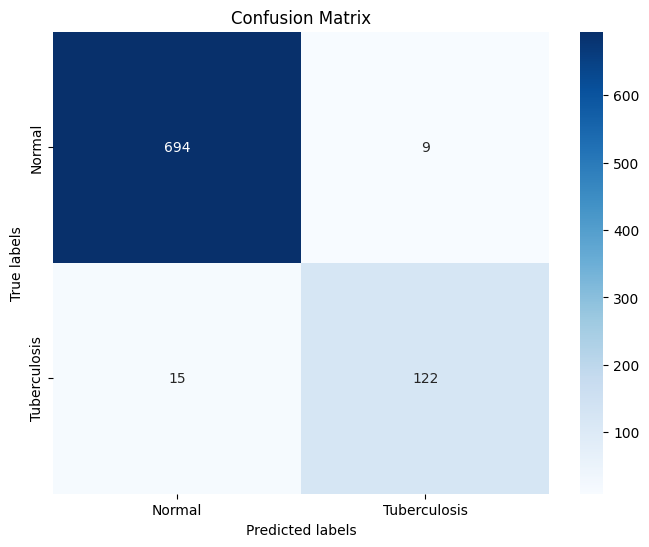

              precision    recall  f1-score   support

      Normal       0.98      0.99      0.98       703
Tuberculosis       0.93      0.89      0.91       137

    accuracy                           0.97       840
   macro avg       0.96      0.94      0.95       840
weighted avg       0.97      0.97      0.97       840



In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model

# Load the best model
best_model = load_model('best_ghostnet_model.h5')

# Predict on the test dataset
y_pred = np.argmax(best_model.predict(test_dataset), axis=-1)

# Get true labels
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate performance metrics
accuracy = np.trace(cm) / np.sum(cm)
precision = cm[1, 1] / np.sum(cm[:, 1])
recall = cm[1, 1] / np.sum(cm[1, :])
sensitivity = recall

# Print the performance metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("Sensitivity:", sensitivity)

# Generate a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Tuberculosis"], yticklabels=["Normal", "Tuberculosis"])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
print(classification_report(y_true, y_pred, target_names=["Normal", "Tuberculosis"]))


In [ ]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define paths
data_dir = '/content/TB_Chest_Radiography_Database'
normal_dir = os.path.join(data_dir, 'Normal')
tb_dir = os.path.join(data_dir, 'Tuberculosis')

# Load images and labels
normal_images = [os.path.join(normal_dir, img) for img in os.listdir(normal_dir)]
tb_images = [os.path.join(tb_dir, img) for img in os.listdir(tb_dir)]
images = normal_images + tb_images
labels = [0] * len(normal_images) + [1] * len(tb_images)  # 0 for normal, 1 for tuberculosis

# Resize and normalize images
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))  # Resize to common size
    img = img.astype(np.float32) / 255.0  # Normalize pixel values
    return img

# Preprocess all images
processed_images = [preprocess_image(img) for img in images]

# Split dataset into train and test sets
train_images, test_images, train_labels, test_labels = train_test_split(processed_images, labels, test_size=0.2, random_state=42)

# Convert to TensorFlow tensors
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).map(lambda x, y: (x, tf.cast(y, tf.float32)))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).map(lambda x, y: (x, tf.cast(y, tf.float32)))

# Shuffle and batch the datasets
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(buffer_size=len(train_images)).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

# GhostNet block
def ghost_module(x, out_channels, ratio=2, dw_size=3, strides=1, activation=True):
    init_channels = int(np.ceil(out_channels / ratio))
    new_channels = int(init_channels * (ratio - 1))

    primary_conv = layers.Conv2D(init_channels, 1, strides=strides, padding='same', use_bias=False)(x)
    primary_conv = layers.BatchNormalization()(primary_conv)
    if activation:
        primary_conv = layers.ReLU()(primary_conv)

    cheap_operation = layers.DepthwiseConv2D(dw_size, 1, padding='same', use_bias=False)(primary_conv)
    cheap_operation = layers.BatchNormalization()(cheap_operation)
    if activation:
        cheap_operation = layers.ReLU()(cheap_operation)

    out = layers.Concatenate(axis=-1)([primary_conv, cheap_operation])
    out = layers.Conv2D(out_channels, 1, padding='same', use_bias=False)(out)
    out = layers.BatchNormalization()(out)

    return out

# GhostNet model
def create_ghostnet(input_shape, num_classes, learning_rate=0.001, dropout_rate=0.5):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(16, 3, 2, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = ghost_module(x, 16)
    x = ghost_module(x, 24, strides=2)
    x = ghost_module(x, 24)

    x = ghost_module(x, 40, strides=2)
    x = ghost_module(x, 40)

    x = ghost_module(x, 80, strides=2)
    x = ghost_module(x, 80)
    x = ghost_module(x, 80)
    x = ghost_module(x, 80)

    x = ghost_module(x, 160, strides=2)
    x = ghost_module(x, 160)

    x = ghost_module(x, 320, strides=1)
    x = layers.Conv2D(1280, 1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)

    # Compile the model
    optimizer = optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Define input shape and number of classes
input_shape = (224, 224, 3)
num_classes = 2  # 2 classes: Normal and Tuberculosis

# Define hyperparameters for tuning
learning_rates = [0.001, 0.0001]
dropout_rates = [0.5, 0.7]
epochs = 10
batch_size = 32
early_stopping_patience = 5  # Adjusted early stopping patience

best_model = None
best_accuracy = 0.0

# Perform hyperparameter tuning
for learning_rate in learning_rates:
    for dropout_rate in dropout_rates:
        print(f"Training model with learning rate: {learning_rate}, dropout rate: {dropout_rate}")

        # Create the GhostNet model
        model = create_ghostnet(input_shape, num_classes, learning_rate, dropout_rate)

        # Define callbacks
        early_stopping = EarlyStopping(monitor='val_loss', patience=early_stopping_patience, restore_best_weights=True)
        model_checkpoint = ModelCheckpoint(filepath='ghostnet_best_model.h5', monitor='val_loss', save_best_only=True)

        # Train the model
        history = model.fit(train_dataset, epochs=epochs, batch_size=batch_size,
                            validation_data=test_dataset, callbacks=[early_stopping, model_checkpoint])

        # Evaluate the model
        _, test_accuracy = model.evaluate(test_dataset)

        print(f"Test accuracy for current configuration: {test_accuracy}")

        # Check if current model is the best so far
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            best_model = model

print("Hyperparameter tuning completed.")
print(f"Best test accuracy: {best_accuracy}")

# Save the best model
best_model.save('best_ghostnet_model.h5')


Training model with learning rate: 0.001, dropout rate: 0.5
Epoch 1/10
105/105 [==============================] - ETA: 0s - loss: 0.2467 - accuracy: 0.9071

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


105/105 [==============================] - 179s 2s/step - loss: 0.2467 - accuracy: 0.9071 - val_loss: 1.1172 - val_accuracy: 0.1631
Epoch 2/10
105/105 [==============================] - 159s 2s/step - loss: 0.1183 - accuracy: 0.9568 - val_loss: 1.7721 - val_accuracy: 0.1631
Epoch 3/10
105/105 [==============================] - 161s 2s/step - loss: 0.1013 - accuracy: 0.9625 - val_loss: 2.5051 - val_accuracy: 0.1631
Epoch 4/10
105/105 [==============================] - 174s 2s/step - loss: 0.0650 - accuracy: 0.9792 - val_loss: 2.8837 - val_accuracy: 0.1631
Epoch 5/10
105/105 [==============================] - 159s 2s/step - loss: 0.0568 - accuracy: 0.9774 - val_loss: 3.3586 - val_accuracy: 0.2179
Epoch 6/10
105/105 [==============================] - 159s 2s/step - loss: 0.0563 - accuracy: 0.9821 - val_loss: 0.2633 - val_accuracy: 0.8988
Epoch 7/10
105/105 [==============================] - 162s 2s/step - loss: 0.0445 - accuracy: 0.9830 - val_loss: 0.1246 - val_accuracy: 0.9524
Epoch 8/10

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model

# Load the best model
best_model = load_model('best_ghostnet_model.h5')

# Predict on the test dataset
y_pred = np.argmax(best_model.predict(test_dataset), axis=-1)

# Get true labels
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate performance metrics
accuracy = np.trace(cm) / np.sum(cm)
precision = cm[1, 1] / np.sum(cm[:, 1])
recall = cm[1, 1] / np.sum(cm[1, :])
sensitivity = recall

# Print the performance metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("Sensitivity:", sensitivity)

# Generate a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Tuberculosis"], yticklabels=["Normal", "Tuberculosis"])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
print(classification_report(y_true, y_pred, target_names=["Normal", "Tuberculosis"]))


: 

In [ ]:
!apt update